In [163]:
import matplotlib.pyplot as plt
import numpy as np
import copy
import scipy as si
import os
import scipy.stats as stats
cwd = os.getcwd()
plots = os.path.join(cwd, 'plots')
max_anlge = 59.2 #deg



def read_from(data, theta, max_anlge = 59.2):
    time = (data[0] - data[0][0])*1e-6 #time in seconds
    angles = np.array([data[9], data[10]])
    tangents  = np.array([data[7], data[8]])
    quadrants = np.array([data[2], data[3], data[4], data[5]])
    totals = data[6]
    gamma = data[1]/16*0.9
    tan_gamma = np.tan(gamma/180*np.pi)
    # this is true_alpha, true_beta type shape
    true_tangents =  np.array([tan_gamma * np.cos(theta/180*np.pi),- tan_gamma * np.sin(theta/180*np.pi)])
    true_angles = np.array([np.arctan(true_tangents[0])*180/np.pi, np.arctan(true_tangents[1])*180/np.pi])
    # find the limits in which the sun sensor works
    dgsa = (true_angles[0] < max_anlge) & (true_angles[0] > -max_anlge)
    dgsb = (true_angles[1] < max_anlge) & (true_angles[1] > -max_anlge)
    return {"time": time, "quadrants": quadrants, "totals": totals,
            "angles": angles, "tangents": tangents, "true_angles": true_angles,
            "true_tangents": true_tangents, "limits": dgsa & dgsb}

def read_from_albedo(data, theta, albedo_angle ,max_anlge = 59.2):
    # this is a fkn copy but with the position of the albedo error included
    time = (data[0] - data[0][0])*1e-6 #time in seconds
    angles = np.array([data[9], data[10]])
    tangents  = np.array([data[7], data[8]])
    quadrants = np.array([data[2], data[3], data[4], data[5]])
    totals = data[6]
    gamma = data[1]/16*0.9
    tan_gamma = np.tan(gamma/180*np.pi)
    # this is true_alpha, true_beta type shape
    true_tangents =  np.array([tan_gamma * np.cos(theta/180*np.pi),- tan_gamma * np.sin(theta/180*np.pi)])
    true_angles = np.array([np.arctan(true_tangents[0])*180/np.pi, np.arctan(true_tangents[1])*180/np.pi])
    # calculate the position of the albedo sources
    albedo_gamma = gamma + albedo_angle
    tan_albedo_gamma = np.tan(albedo_gamma/180*np.pi)
    albedo_tangents = np.array([tan_albedo_gamma * np.cos(theta/180*np.pi),- tan_albedo_gamma * np.sin(theta/180*np.pi)])
    albedo_angles = np.array([np.arctan(albedo_tangents[0])*180/np.pi, np.arctan(albedo_tangents[1])*180/np.pi])
    # find the limits in which the sun sensor works
    #calculate the position of the albedo source
    dgsa = (true_angles[0] < max_anlge) & (true_angles[0] > -max_anlge)
    dgsb = (true_angles[1] < max_anlge) & (true_angles[1] > -max_anlge)
    return {"time": time, "quadrants": quadrants, "totals": totals,
            "angles": angles, "tangents": tangents, "true_angles": true_angles,
            "true_tangents": true_tangents, "limits": dgsa & dgsb, "albedo_tangents": albedo_tangents, "albedo_angles": albedo_angles}

unbaffled_dir = os.path.join(cwd, r'data\unbaffled_albedo_test')
calb_data = [read_from((np.loadtxt(unbaffled_dir + r'\180_noalbedo1_max70', skiprows=1, delimiter=',')).T, 180),
             read_from((np.loadtxt(unbaffled_dir + r'\135_noalbedo1_max70', skiprows=1, delimiter=',')).T, 135),
             read_from((np.loadtxt(unbaffled_dir + r'\90_noalbedo1_max70', skiprows=1, delimiter=',')).T, 90),
             read_from((np.loadtxt(unbaffled_dir + r'\45_noalbedo1_max70', skiprows=1, delimiter=',')).T, 45)]

test_data = [read_from((np.loadtxt(unbaffled_dir + r'\180_noalbedo2_max70', skiprows=1, delimiter=',')).T, 180),
             read_from((np.loadtxt(unbaffled_dir + r'\135_noalbedo2_max70', skiprows=1, delimiter=',')).T, 135),
             read_from((np.loadtxt(unbaffled_dir + r'\90_noalbedo2_max70', skiprows=1, delimiter=',')).T, 90),
             read_from((np.loadtxt(unbaffled_dir + r'\45_noalbedo2_max70', skiprows=1, delimiter=',')).T, 45)]

val_data = [read_from((np.loadtxt(unbaffled_dir + r'\180_noalbedo3_max70', skiprows=1, delimiter=',')).T, 180),
            read_from((np.loadtxt(unbaffled_dir + r'\135_noalbedo3_max70', skiprows=1, delimiter=',')).T, 135),
            read_from((np.loadtxt(unbaffled_dir + r'\90_noalbedo3_max70', skiprows=1, delimiter=',')).T, 90),
            read_from((np.loadtxt(unbaffled_dir + r'\45_noalbedo3_max70', skiprows=1, delimiter=',')).T, 45)]



def gaussian(avg,rms,values):
    pdf = 1/(np.sqrt(2*np.pi)*rms) * np.exp(-(values-avg)**2/(2*rms**2))
    return pdf

def chi_test(errors, error_goal, rms):
    # this calculates the probability to get our data give the error is (below or above?) the goal
    # this function is useless as it only returns 1 or 0 bc our error is so off
    n = len(errors)
    #calculate chi square
    X2 = (n-1)*rms**2/(error_goal/2)**2
    p_value = 1 - si.stats.chi2.cdf(X2, df=n-1)
    return n, X2

def chi_calculator(errors, error_goal, interval = 0.05, interval_size = 2):
    # calculates the chi that we should see vs that we see
    n = len(errors)
    rms = np.sqrt(np.average(errors**2))
    X2 = (n-1)*rms**2/(error_goal/interval_size)**2
    critical_value = si.stats.chi2.ppf(1 - interval, n)
    failures = len(errors[np.where(errors>error_goal)])
    #print(f"The critical value for alpha={interval} and df={n} is: {critical_value}")
    return {"dof":n ,"chi": X2, "crit":critical_value, "goal error (2sigma)": error_goal, "failure fraction": failures/n, "measured rms": rms}

def error_distribution(data_set, title, save = False, path = None, separate = False):
    """
    Does all the statistics on the data such as getting variance, P values and plotting sample distribution.
    errors are of the form measured -  true
    :return: idk
    """
    prep_errors = lambda data_part : (data_part["angles"] - data_part["true_angles"])[:,data_part["limits"]]
    error_set = np.hstack([prep_errors(data_set[i]) for i in range(4)])
    # make continuous version of error pdf
    max_err = np.max(error_set)
    # rms is our average root mean square error
    rms = np.sqrt(np.average(np.sum(error_set**2,axis=0)))
    print(rms)
    mean = np.mean(error_set)
    ctu = np.linspace(mean -max_err - 1, mean + max_err + 1, 1000)
    counts, bins = np.histogram(error_set[0], bins=100)
    bin_width = bins[1] - bins[0]
    pdf = bin_width * (len(error_set[0]) + len(error_set[1]))* gaussian(mean, np.sqrt(np.var(error_set)), ctu)
    fig, ax = plt.subplots(ncols=1, figsize = (5,4))
    fig.suptitle(title)
    euc_err = np.sqrt(np.sum(error_set**2,axis=0))
    if separate:
        ax.hist(error_set[0], bins=100, color = "tab:orange" ,label = r"rms $\alpha$", alpha = 0.7)
        ax.hist(error_set[1], bins=100, color = "tab:green" ,label = r"rms $\beta$", alpha = 0.7)
        ax.plot(ctu, pdf, label = "combined pdf")
    else:
        ax.hist(euc_err, bins=100, color = "tab:red" ,label = r"errors $\sqrt{rms_{\alpha}^2 + rms_{\beta}^2}$", alpha = 0.7)
    ax.legend(loc=1)
    ax.set_xlabel("error (deg)")
    ax.set_ylabel("counts")
    ax.legend()
    plt.tight_layout()
    if save:
        plt.savefig(path)
    plt.show()
    plt.close(fig)
    return euc_err, rms

In [161]:
#load the baffled data that has no albedo error
baffled_dir = os.path.join(cwd, r'data\baffled_tests')
calb_data_baffled = [read_from((np.loadtxt(baffled_dir + r'\180_noalbedo1_baffled_max70', skiprows=1, delimiter=',')).T, 180),
                     read_from((np.loadtxt(baffled_dir + r'\135_noalbedo1_baffled_max70', skiprows=1, delimiter=',')).T, 135),
                     read_from((np.loadtxt(baffled_dir + r'\90_noalbedo1_baffled_max70', skiprows=1, delimiter=',')).T, 90),
                     read_from((np.loadtxt(baffled_dir + r'\45_noalbedo1_baffled_max70', skiprows=1, delimiter=',')).T, 45)]

test_data_baffled = [read_from((np.loadtxt(baffled_dir + r'\180_noalbedo2_baffled_max70', skiprows=1, delimiter=',')).T, 180),
                     read_from((np.loadtxt(baffled_dir + r'\135_noalbedo2_baffled_max70', skiprows=1, delimiter=',')).T, 135),
                     read_from((np.loadtxt(baffled_dir + r'\90_noalbedo2_baffled_max70', skiprows=1, delimiter=',')).T, 90),
                     read_from((np.loadtxt(baffled_dir + r'\45_noalbedo2_baffled_max70', skiprows=1, delimiter=',')).T, 45)]

val_data_baffled = [read_from((np.loadtxt(baffled_dir + r'\180_noalbedo3_baffled_max70', skiprows=1, delimiter=',')).T, 180),
                    read_from((np.loadtxt(baffled_dir + r'\135_noalbedo3_baffled_max70', skiprows=1, delimiter=',')).T, 135),
                    read_from((np.loadtxt(baffled_dir + r'\90_noalbedo3_baffled_max70', skiprows=1, delimiter=',')).T, 90),
                    read_from((np.loadtxt(baffled_dir + r'\45_noalbedo3_baffled_max70', skiprows=1, delimiter=',')).T, 45)]

In [162]:
# Plot true vs measured. Use the calibration data of measurement 1
def generic_angles(data_set, title , save = False, path = None, albedo_angle = False):
    # Get the right orientations
    orientations = ["180", "135", "90", "45"]
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,8))
    fig.suptitle(title)
    for k in range(4):
        data = data_set[k]
        j, i = k, 0
        if k > 1:
            j, i = k - 2, 1
        ax[i][j].set_title(f"orientation: {orientations[k]} deg")
        ax[i][j].scatter(data["true_angles"][0], data["angles"][0], c='tab:orange', marker='.', label=r'$\alpha$')
        ax[i][j].scatter(data["true_angles"][1], data["angles"][1], c='tab:green', marker='.', label=r'$\beta$')
        if albedo_angle:
            ax[i][j].scatter(data["albedo_angles"][0], data["albedo_angles"][0], c='tab:red', marker='.',s=0.1,alpha=0.8, label=r'$\alpha_{albedo}$')
            ax[i][j].scatter(data["albedo_angles"][1], data["albedo_angles"][1], c='tab:grey', marker='.',s=0.1,alpha=0.8, label=r'$\beta_{albedo}$')
        ax[i][j].set_xlabel("true angle (deg)")
        ax[i][j].set_ylabel("measured angle (deg)")
        ax[i][j].legend(loc=2)
        ax[i][j].grid()
    plt.tight_layout()
    if save:
        plt.savefig(path)
    plt.show()
    plt.close(fig)

#generic_angles(calb_data, "calibration data")


Optimize with a bias/offset on the quadcell formula. Obviously, the quadcell can be programmed to have this offset
We now use:
$
    \frac{\tan{\alpha}}{\tan{\alpha_{max}}} = S_a - C_a \\
$
where $S_a$ is the quadcell formula. $\beta$ gets similar treatment. It is now a matter of finding optimal $C_a$ and $C_b$ that must be applicable to every orientation (it shouldn't matter how we place the sun sensor as long as it is properly alligned)\\

Optimize with linear coefficients and bias/offset on the quadcell formula. (Also programmable in arduino)\\

Next: Truth table based on nearest neighbors

In [170]:
# put all calibration methods in here
# get the offset coefficient tb used on a test set
def quad_formula(norm_quadrants):
    tan_a = norm_quadrants[0] + norm_quadrants[3] - norm_quadrants[2] - norm_quadrants[1]
    tab_b = norm_quadrants[0] + norm_quadrants[1]  - norm_quadrants[3] - norm_quadrants[2]
    return np.array([tan_a, tab_b])

def get_offset(data_set):
    # since the tangents are only 2 decimal numbers, use the quadrant info
    prep_quads = lambda data_partition : data_partition["quadrants"][:, data_partition["limits"]]/data_partition["totals"][data_partition["limits"]]
    prep_true_tans = lambda data_partition : data_partition["true_tangents"][:, data_partition["limits"]]
    #prep_tans = lambda data_partition : data_partition["tans"][:, data_partition["limits"]]
    # stack the tangents data in a convienient way
    tangents = np.hstack([quad_formula(prep_quads(data_set[i])) for i in range(4)])
    #tangents = np.hstack([prep_tans(data_set[i]) for i in range(4)])
    true_tangents = np.hstack([prep_true_tans(data_set[i]) for i in range(4)])
    loss_a = np.average(tangents[0] - true_tangents[0])
    loss_b = np.average(tangents[1] - true_tangents[1])
    return np.array([loss_a, loss_b])

# apply bias on test set and see
def apply_offset(data_set, bias):
    bias = bias.reshape(-1,1)
    # deepcopy is needed or python will just change the og data by reference
    corrected = []
    for i in range(4):
        data = copy.deepcopy(data_set[i])
        data["tangents"] -= bias
        data["angles"] = np.arctan(data["tangents"])*180/np.pi
        corrected.append(data)
    return corrected


# OLS
def OLS(data_set, yval = "alpha",regularization = 0.01, add_bias = False, max_anlge = 59.2):
    """
    :return: an estimator for either alpha or beta. not both
    """
    # calculate the tangents based on a least squares estimator
    # default data is in transpose form
    assert yval in ["alpha", "beta"], "yval should be alpha or beta"
    if yval == "alpha":
        dig = 0
    elif yval == "beta":
        dig = 1
    # select the "good" cells for
    prep_quads = lambda data_partition : data_partition["quadrants"][:, data_partition["limits"]]/data_partition["totals"][data_partition["limits"]]
    quadrant_data_transpose = np.hstack([prep_quads(data_set[i]) for i in range(4)])
    prep_true_tans = lambda data_partition : data_partition["true_tangents"][:, data_partition["limits"]]
    true_tangent_fraction = np.hstack([prep_true_tans(data_set[i]) for i in range(4)])/np.tan(max_anlge*np.pi/180)
    if add_bias:
        ones = np.full_like(quadrant_data_transpose[0],1).reshape(1,-1)
        quadrant_data_transpose = np.vstack((quadrant_data_transpose, ones))
    #print(quadrant_data_transpose[:,:10])
    quadrant_data = quadrant_data_transpose.T
    inverted_part = np.linalg.inv(np.dot(quadrant_data_transpose,quadrant_data) + regularization)
    estimator = np.dot(np.dot(inverted_part, quadrant_data_transpose), true_tangent_fraction[dig])
    return estimator

def apply_OLS(data_set, ols_a, ols_b, bias = False, max_anlge = 59.2):
    # use the estimator to predict the tangenst and angles
    # note that to calculate the angles, even out of bounds values are used
    prep_quads = lambda data_partition : data_partition["quadrants"]/data_partition["totals"]
    # yes this should be applied to each data orientation separately
    # bc they must be returned separately
    corrected = []
    for k in range(len(data_set)):
        data = copy.deepcopy(data_set[k])
        quadrant_transpose = prep_quads(data)
        if bias:
            ones = np.full_like(quadrant_transpose[0],1).reshape(1,-1)
            quadrant_transpose = np.vstack((quadrant_transpose, ones))
        data["tangents"] = np.array([np.dot(quadrant_transpose.T,ols_a), np.dot(quadrant_transpose.T,ols_b)]) * np.tan(max_anlge*np.pi/180)
        data["angles"] = np.arctan(data["tangents"])*180/np.pi
        corrected.append(data)
    return corrected


#LUT
def lookup_table(data_set, averaging = 100):
    # the table include quadrant info and their specific true angles
    prep_quads = lambda data_partition : data_partition["quadrants"][:, data_partition["limits"]]/data_partition["totals"][data_partition["limits"]]
    prep_true_ang = lambda data_partition : data_partition["true_angles"][:, data_partition["limits"]]
    #only calibrate within limit quadrants
    quadrants = np.hstack([prep_quads(data_set[i]) for i in range(4)])
    quadrants_split = np.array(np.split(quadrants, len(quadrants[0])/averaging, axis = 1))
    quadrant_average = np.average(quadrants_split, axis = 2)
    quadrant_variance = np.var(quadrants_split, axis = 2)
    distance_estimate = np.sum(quadrant_variance,axis=1)
    true_angles = np.hstack([prep_true_ang(data_set[i]) for i in range(4)])
    true_angles_avg = true_angles[:,::averaging]
    table = {"quadrants" : quadrant_average, "true_angles" : true_angles_avg, "quadrant_variance": distance_estimate}
    return table

def apply_table(data_set, LUT):
    prep_quads = lambda data_partition : data_partition["quadrants"]/data_partition["totals"]
    data = copy.deepcopy(data_set)
    for k in range(len(data_set)):
        data_part = copy.deepcopy(data[k])
        quadrants = prep_quads(data_part).T
        # again correction will be applied to each orientation separately
        print(data[k]["angles"].shape)
        print(LUT["true_angles"].shape)
        for i in range(len(quadrants[:,0])):
            distance = np.sqrt(np.sum((quadrants[i] - LUT["quadrants"])**2,axis=1))
            index = distance.argmin()
            data[k]["angles"][:,i] = LUT["true_angles"][:,index]
    return data



In [172]:
# calibration step for unbaffled data
bias = get_offset(calb_data)
table = lookup_table(calb_data)
# calculate the estimator using calibration data [0], test it on [1]
estimator_alpha_1 = OLS(calb_data, yval="alpha", add_bias = True)
estimator_beta_1 = OLS(calb_data, yval="beta", add_bias = True)

working with calibration method: raw


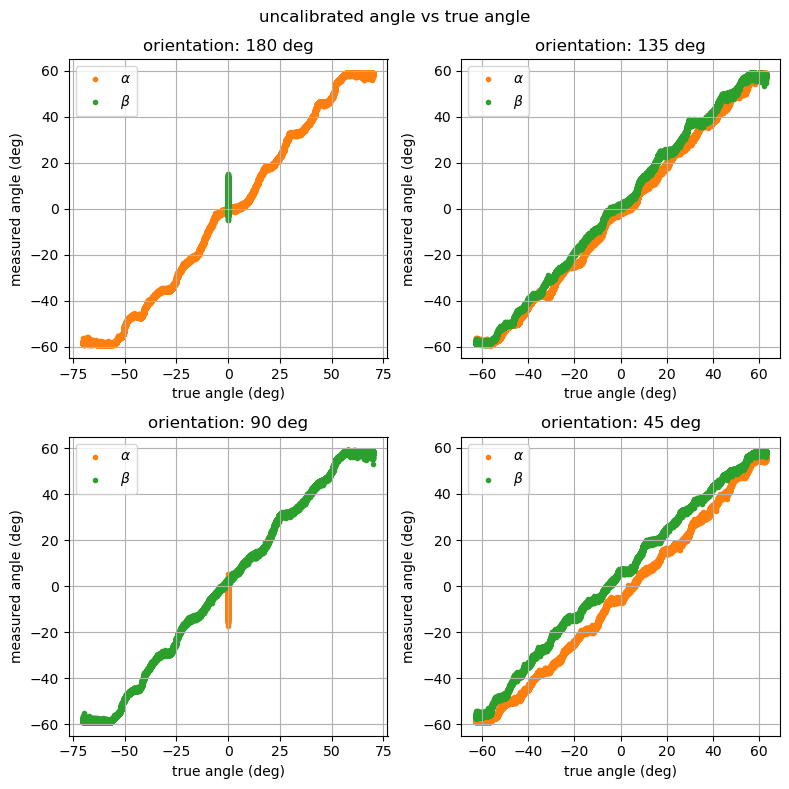

5.151232093196278


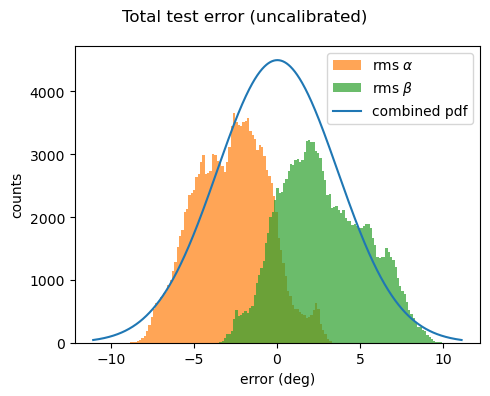

{'dof': 145200, 'chi': 1258084.360662836, 'crit': 146087.52703094852, 'goal error (2sigma)': 3.5, 'failure fraction': 0.6139462809917355, 'measured rms': 5.151232093196278}
{'dof': 145200, 'chi': 3852883.354529936, 'crit': 146087.52703094852, 'goal error (2sigma)': 2.0, 'failure fraction': 0.8825619834710744, 'measured rms': 5.151232093196278}
{'dof': 145200, 'chi': 15411533.418119743, 'crit': 146087.52703094852, 'goal error (2sigma)': 1.0, 'failure fraction': 0.9701652892561984, 'measured rms': 5.151232093196278}
working with calibration method: bias


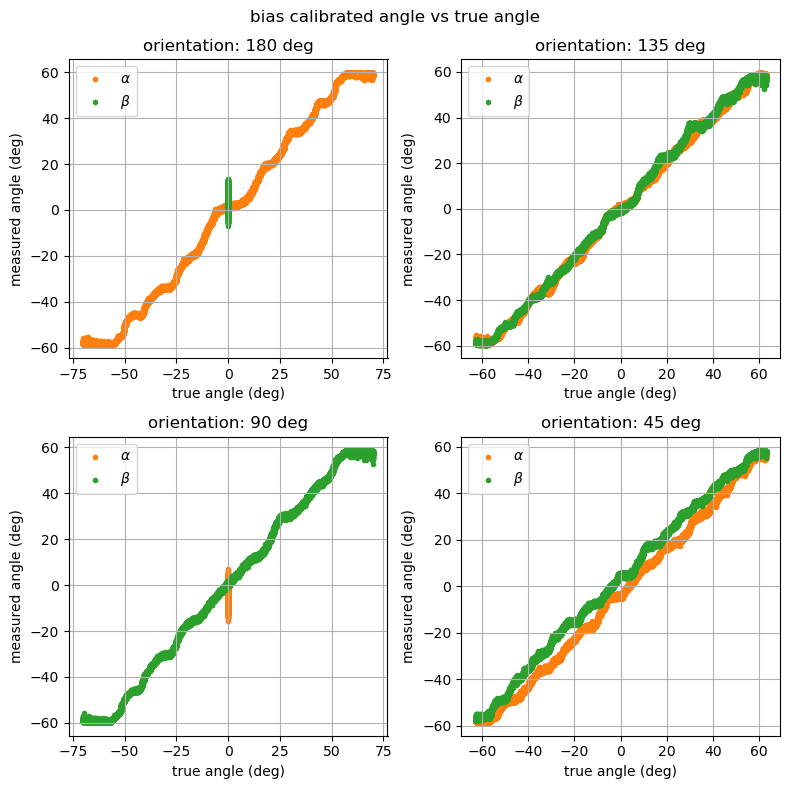

3.786848872982114


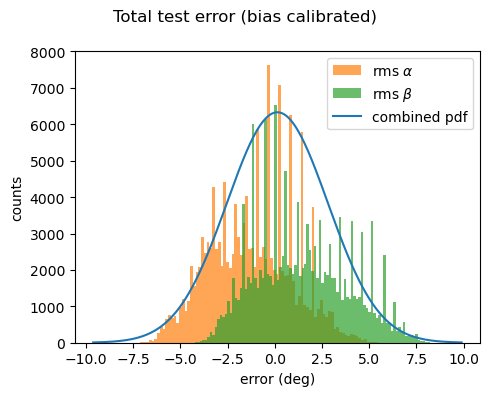

{'dof': 145200, 'chi': 679897.5479966796, 'crit': 146087.52703094852, 'goal error (2sigma)': 3.5, 'failure fraction': 0.39698347107438015, 'measured rms': 3.786848872982114}
{'dof': 145200, 'chi': 2082186.240739831, 'crit': 146087.52703094852, 'goal error (2sigma)': 2.0, 'failure fraction': 0.7122796143250689, 'measured rms': 3.786848872982114}
{'dof': 145200, 'chi': 8328744.962959324, 'crit': 146087.52703094852, 'goal error (2sigma)': 1.0, 'failure fraction': 0.9110743801652893, 'measured rms': 3.786848872982114}
working with calibration method: reg


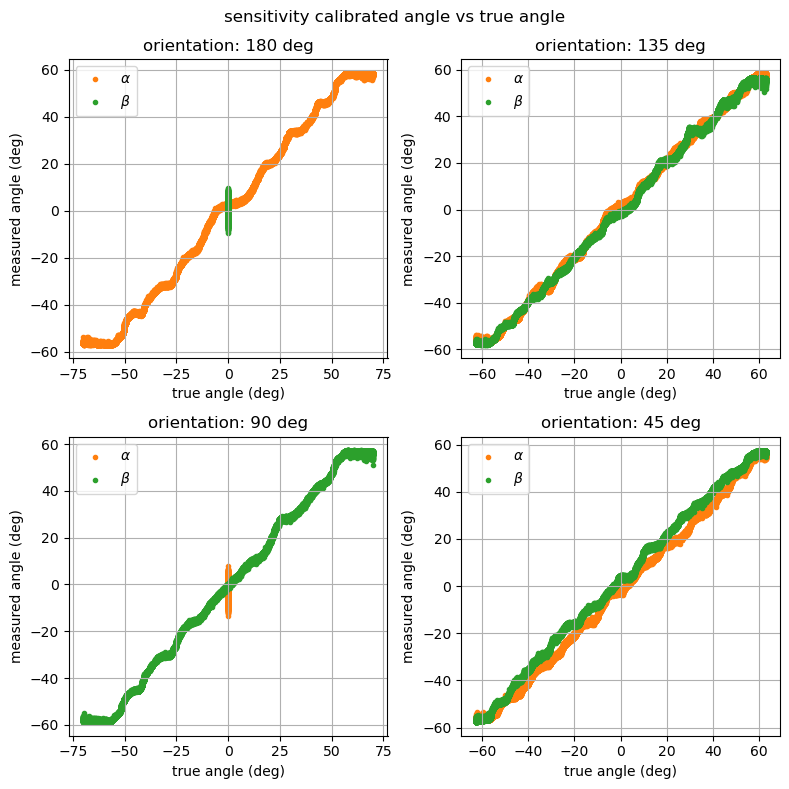

3.1209150947178523


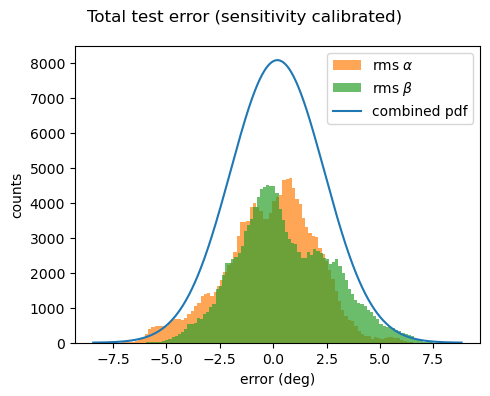

{'dof': 145200, 'chi': 461797.34896918584, 'crit': 146087.52703094852, 'goal error (2sigma)': 3.5, 'failure fraction': 0.24254820936639118, 'measured rms': 3.1209150947178523}
{'dof': 145200, 'chi': 1414254.3812181316, 'crit': 146087.52703094852, 'goal error (2sigma)': 2.0, 'failure fraction': 0.6047107438016529, 'measured rms': 3.1209150947178523}
{'dof': 145200, 'chi': 5657017.5248725265, 'crit': 146087.52703094852, 'goal error (2sigma)': 1.0, 'failure fraction': 0.8570936639118457, 'measured rms': 3.1209150947178523}
working with calibration method: LUT
(2, 40300)
(2, 1452)
(2, 40300)
(2, 1452)
(2, 40300)
(2, 1452)
(2, 40300)
(2, 1452)


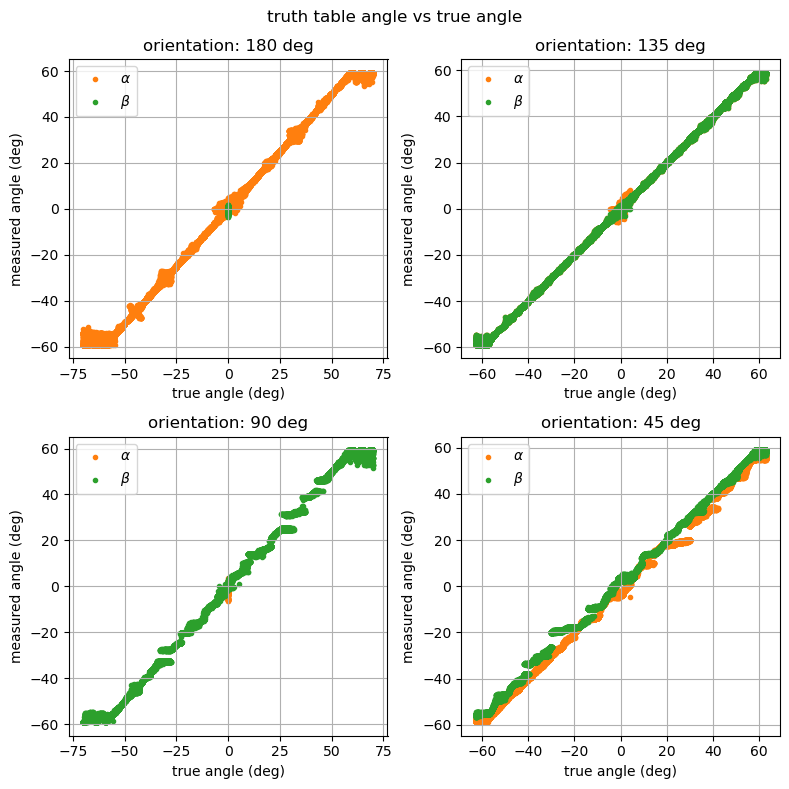

2.2527610481569726


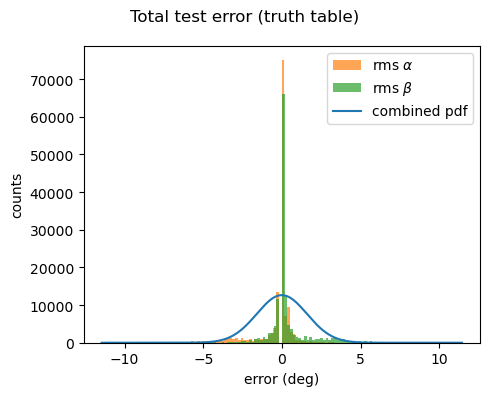

{'dof': 145200, 'chi': 240612.27782831262, 'crit': 146087.52703094852, 'goal error (2sigma)': 3.5, 'failure fraction': 0.10300275482093664, 'measured rms': 2.2527610481569726}
{'dof': 145200, 'chi': 736875.1008492074, 'crit': 146087.52703094852, 'goal error (2sigma)': 2.0, 'failure fraction': 0.17643939393939395, 'measured rms': 2.2527610481569726}
{'dof': 145200, 'chi': 2947500.4033968295, 'crit': 146087.52703094852, 'goal error (2sigma)': 1.0, 'failure fraction': 0.28823691460055095, 'measured rms': 2.2527610481569726}


In [174]:
# make a script that calculates te chisquare value at each calibration method for 1.0, 2.0, and 3.5 degree
goals = [3.5,2.0,1.0]
calibrations = ["raw", "bias", "reg", "LUT"]
titles = ["uncalibrated", "bias calibrated", "sensitivity calibrated", "truth table"]
baffled_plots = os.path.join(plots,"unbaffled")
p_info = {"raw": [], "bias": [], "reg": [], "LUT": []}
rms_dict = {"raw": [], "bias": [], "reg": [], "LUT": []}
for i, method in enumerate(calibrations):
    print("working with calibration method:", method)
    if method=="raw":
        calibrated_testdata = test_data
    elif method=="bias":
        calibrated_testdata = apply_offset(test_data, bias)
    elif method=="reg":
        calibrated_testdata = apply_OLS(test_data, estimator_alpha_1, estimator_beta_1, bias = True)
    elif method=="LUT":
        calibrated_testdata = apply_table(test_data, table)
    test_save_plot = os.path.join(baffled_plots,f"test_save_{method}_plot.png")
    generic_angles(calibrated_testdata, f"{titles[i]} angle vs true angle", save = True, path = test_save_plot)
    test_error_plot = os.path.join(baffled_plots,f"test_save_{method}_error.png")
    euc_err, rms = error_distribution(calibrated_testdata, title = f"Total test error ({titles[i]})", save = True, path = test_error_plot, separate = True)
    rms_dict[method] = rms
    for k in range(3):
        p_info[method].append(chi_calculator(euc_err, error_goal = goals[k], interval = 0.05))
        print(p_info[method][k])

In [175]:
rms_dict

{'raw': 5.151232093196278,
 'bias': 3.786848872982114,
 'reg': 3.1209150947178523,
 'LUT': 2.2527610481569726}

In [178]:
def difference(data_set, set2, title, base_rms , save = False, path = None):
    # Get the right orientations
    # note down the proper albedo error in te plot
    orientations = ["180", "135", "90", "45"]
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,8))
    fig.suptitle(title)
    for k in range(4):
        data = data_set[k]
        locs = data["limits"]
        data2nd = set2[k]
        j, i = k, 0
        ctu = np.sort(data["angles"][0])[locs]
        if k > 1:
            j, i = k - 2, 1
            ctu = np.sort(data["angles"][1])[locs]
        difference = data2nd["angles"] - data["angles"]
        ax[i][j].set_title(f"orientation: {orientations[k]} deg")
        ax[i][j].scatter(data["true_angles"][0][locs], difference[0][locs], c='tab:orange', marker='.', label=r'$\alpha$')
        ax[i][j].scatter(data["true_angles"][1][locs], difference[1][locs], c='tab:green', marker='.', label=r'$\beta$')
        ylim = ax[i][j].get_ylim()
        ax[i][j].set_ylim(ylim[0]*1.2, ylim[1]*1.2)
        ax[i][j].fill_between(ctu, 2*base_rms, -2*base_rms, alpha = 0.4, color = "tab:red", label = "system rms x 2")
        ax[i][j].set_xlabel("true angle (deg)")
        ax[i][j].set_ylabel("albedo error (deg)")
        ax[i][j].legend(loc=2)
        ax[i][j].grid()
    plt.tight_layout()
    if save:
        plt.savefig(path)
    plt.show()
    plt.close(fig)


In [176]:
#load the data including albedo stuff
#the last number signifies the orientation of the light source
albedo_data_90 = [read_from_albedo((np.loadtxt(unbaffled_dir + r'\180_yesalbedo4_90_max70', skiprows=1, delimiter=',')).T, 180, albedo_angle = 90),
                  read_from_albedo((np.loadtxt(unbaffled_dir + r'\135_yesalbedo4_90_max70', skiprows=1, delimiter=',')).T, 135, albedo_angle = 90),
                  read_from_albedo((np.loadtxt(unbaffled_dir + r'\90_yesalbedo4_90_max70', skiprows=1, delimiter=',')).T, 90, albedo_angle = 90),
                  read_from_albedo((np.loadtxt(unbaffled_dir + r'\45_yesalbedo4_90_max70', skiprows=1, delimiter=',')).T, 45, albedo_angle = 90)]

nosun_albedo_data_90 = [read_from_albedo((np.loadtxt(unbaffled_dir + r'\180_nosun_yesalbedo4_90_max70', skiprows=1, delimiter=',')).T, 180, albedo_angle = 90),
                        read_from_albedo((np.loadtxt(unbaffled_dir + r'\135_nosun_yesalbedo4_90_max70', skiprows=1, delimiter=',')).T, 135, albedo_angle = 90),
                        read_from_albedo((np.loadtxt(unbaffled_dir + r'\90_nosun_yesalbedo4_90_max70', skiprows=1, delimiter=',')).T, 90, albedo_angle = 90),
                        read_from_albedo((np.loadtxt(unbaffled_dir + r'\45_nosun_yesalbedo4_90_max70', skiprows=1, delimiter=',')).T, 45, albedo_angle = 90)]

albedo_data_45 = [read_from_albedo((np.loadtxt(unbaffled_dir + r'\180_yesalbedo4_45_max70', skiprows=1, delimiter=',')).T, 180, albedo_angle = 45),
                  read_from_albedo((np.loadtxt(unbaffled_dir + r'\135_yesalbedo4_45_max70', skiprows=1, delimiter=',')).T, 135, albedo_angle = 45),
                  read_from_albedo((np.loadtxt(unbaffled_dir + r'\90_yesalbedo4_45_max70', skiprows=1, delimiter=',')).T, 90, albedo_angle = 45),
                  read_from_albedo((np.loadtxt(unbaffled_dir + r'\45_yesalbedo4_45_max70', skiprows=1, delimiter=',')).T, 45, albedo_angle = 45)]

nosun_albedo_data_45 = [read_from_albedo((np.loadtxt(unbaffled_dir + r'\180_nosun_yesalbedo4_45_max70', skiprows=1, delimiter=',')).T, 180, albedo_angle = 45),
                        read_from_albedo((np.loadtxt(unbaffled_dir + r'\135_nosun_yesalbedo4_45_max70', skiprows=1, delimiter=',')).T, 135, albedo_angle = 45),
                        read_from_albedo((np.loadtxt(unbaffled_dir + r'\90_nosun_yesalbedo4_45_max70', skiprows=1, delimiter=',')).T, 90, albedo_angle = 45),
                        read_from_albedo((np.loadtxt(unbaffled_dir + r'\45_nosun_yesalbedo4_45_max70', skiprows=1, delimiter=',')).T, 45, albedo_angle = 45)]

bright_albedo_data_45 = [read_from_albedo((np.loadtxt(unbaffled_dir + r'\180_BRIGHTalbedo4_45_max70', skiprows=1, delimiter=',')).T, 180, albedo_angle = 45),
                         read_from_albedo((np.loadtxt(unbaffled_dir + r'\135_BRIGHTalbedo4_45_max70', skiprows=1, delimiter=',')).T, 135, albedo_angle = 45)]


working with calibration method: raw


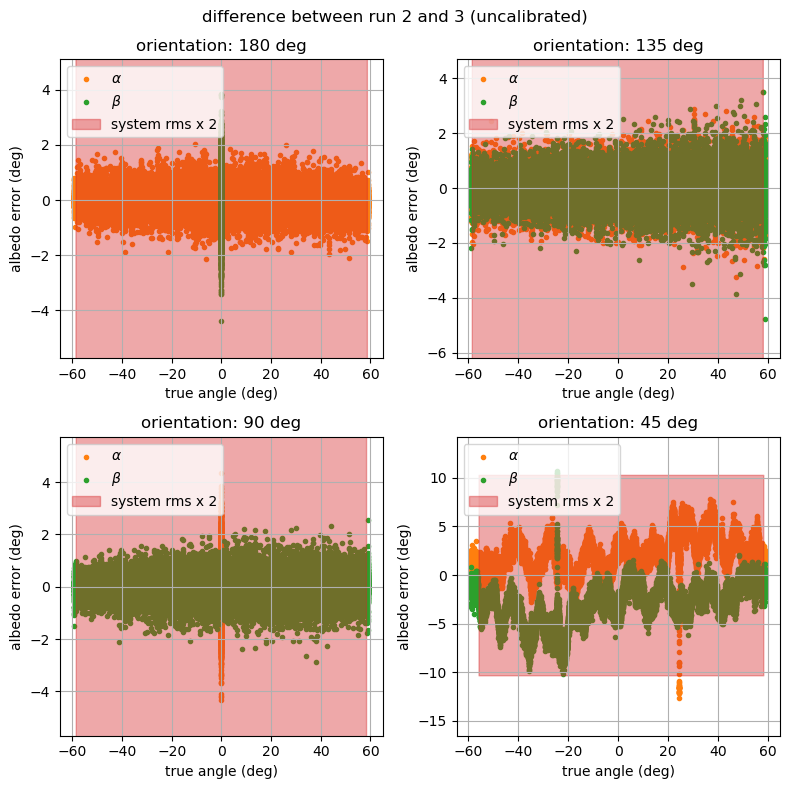

working with calibration method: bias


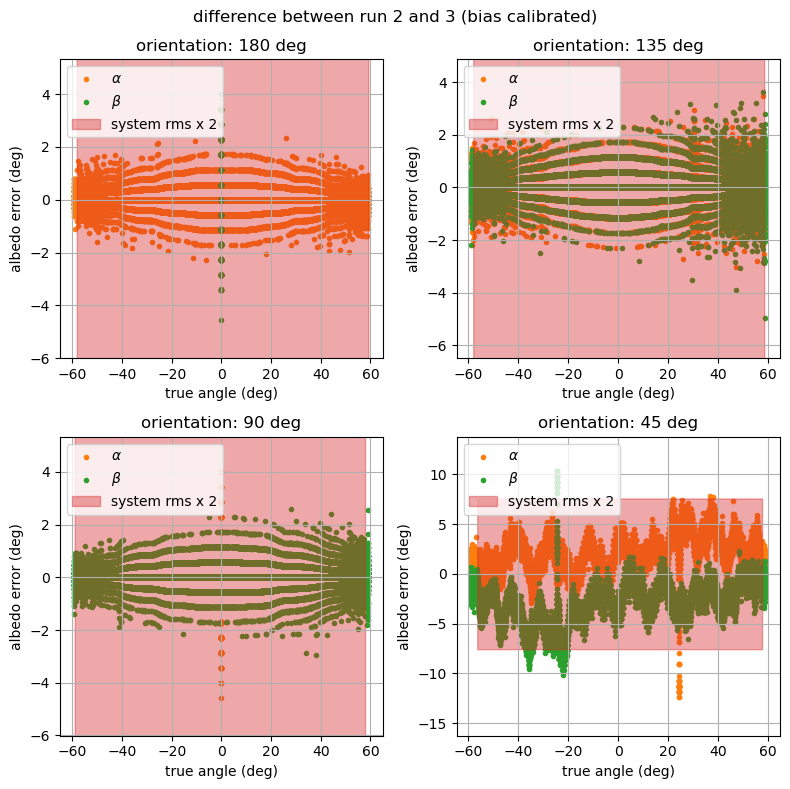

working with calibration method: reg


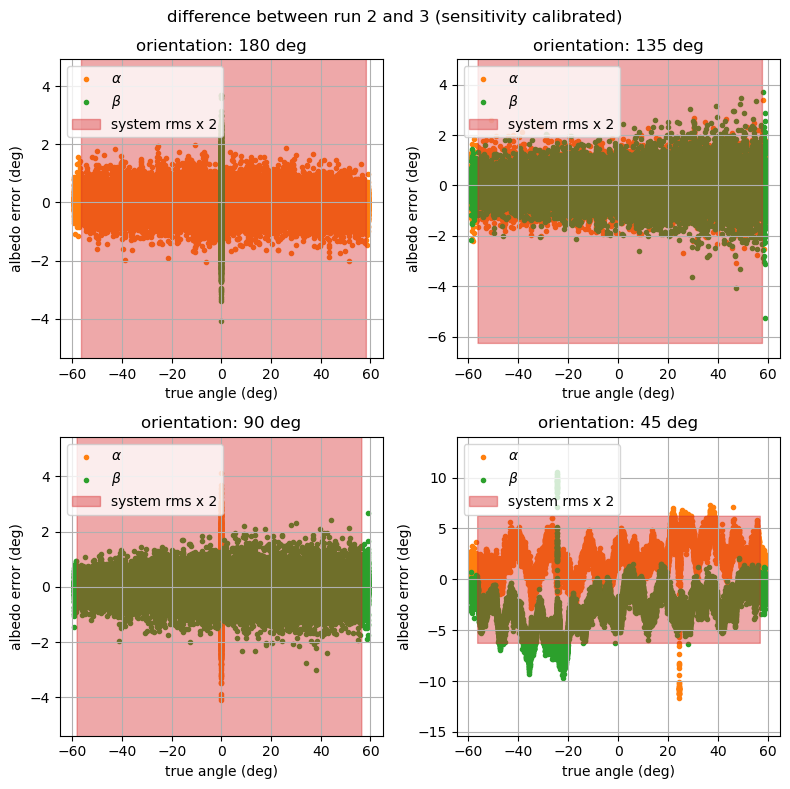

working with calibration method: LUT
(2, 40300)
(2, 1452)
(2, 40300)
(2, 1452)
(2, 40300)
(2, 1452)
(2, 40300)
(2, 1452)
(2, 40300)
(2, 1452)
(2, 40300)
(2, 1452)
(2, 40300)
(2, 1452)
(2, 40300)
(2, 1452)


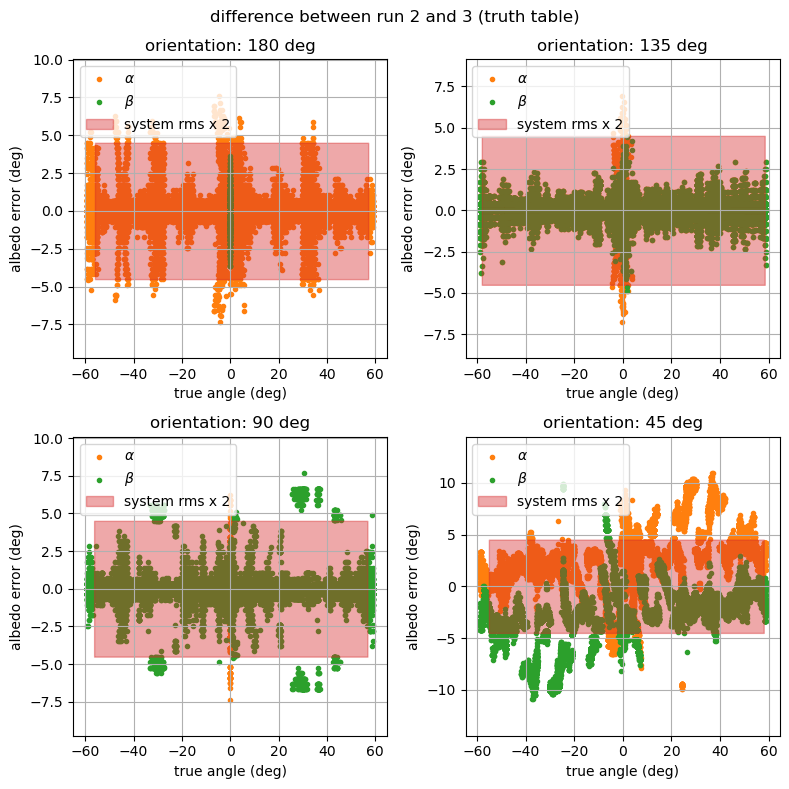

In [136]:
# use calibration on the albedo error induding data for the basic case
# this was rather inconclusive
albedo_orientation=90
show_error = True
set2 = val_data
data_set = test_data
rms_type = rms_dict
title_difference = "difference between run 2 and 3"

calibrations = ["raw", "bias", "reg", "LUT"]
titles = ["uncalibrated", "bias calibrated", "sensitivity calibrated", "truth table"]
unbaffled_alb_plots = os.path.join(plots,"unbaffled_albedo_err")
p_info = {"raw": [], "bias": [], "reg": [], "LUT": []}
for i, method in enumerate(calibrations):
    print("working with calibration method:", method)
    if method=="raw":
        calibrated_testdata = data_set
        calibrated_2ndset = set2
    elif method=="bias":
        calibrated_testdata = apply_offset(data_set, bias)
        calibrated_2ndset = apply_offset(set2, bias)
    elif method=="reg":
        calibrated_testdata = apply_OLS(data_set, estimator_alpha_1, estimator_beta_1, bias = True)
        calibrated_2ndset = apply_OLS(set2, estimator_alpha_1, estimator_beta_1, bias = True)
    elif method=="LUT":
        calibrated_testdata = apply_table(test_data, table)
        calibrated_2ndset = apply_table(set2, table)

    if show_error:
        test_save_plot = os.path.join(unbaffled_alb_plots,f"test_save_{method}_difference_{albedo_orientation}_plot.png")
        difference(calibrated_testdata, calibrated_2ndset, f"{title_difference} ({titles[i]})", base_rms = rms_dict[method], save = True, path = test_save_plot)
    else:
        test_save_plot = os.path.join(unbaffled_alb_plots,f"test_save_{method}_albedo_{albedo_orientation}_plot.png")
        generic_angles(calibrated_2ndset, f"Angles with albedo error ({titles[i]})", save = True, path = test_save_plot, albedo_angle=False)
        test_error_plot = os.path.join(unbaffled_alb_plots,f"test_save_{method}_error_euclidian.png")
        euc_err, rms = error_distribution(calibrated_2ndset, title = f"Total test error ({titles[i]})", save = True, path = test_error_plot)

In [177]:
def bright_albedo_plots(data_set, albedo_set, title , base_rms, save = False, path = None):
    orientations = ["180", "135"]
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9,4))
    fig.suptitle(title)
    for k in range(2):
        data = data_set[k]
        albedo_data = albedo_set[k]
        locs = data["limits"]
        ctu = np.sort(data["angles"][k])[locs]
        difference = data["angles"] - albedo_data["angles"]
        ax[k].scatter(data["true_angles"][0][locs], difference[0][locs], c='tab:orange', marker='.', label=r'$\alpha$')
        ax[k].scatter(data["true_angles"][1][locs], difference[1][locs], c='tab:green', marker='.', label=r'$\beta$')
        ax[k].set_title(f"orientation: {orientations[k]} deg")
        ylim = ax[k].get_ylim()
        ax[k].set_ylim(ylim[0]*1.2, ylim[1]*1.2)
        ax[k].fill_between(ctu, 2*base_rms, -2*base_rms, alpha = 0.4, color = "tab:red", label = "system rms x 2")
        ax[k].legend(loc=2)
        ax[k].grid()
        plt.tight_layout()
    if save:
        plt.savefig(path)
    plt.show()
    plt.close(fig)

(2, 40300)
(2, 1452)
(2, 40300)
(2, 1452)
(2, 40300)
(2, 1452)
(2, 40300)
(2, 1452)
(2, 40300)
(2, 1452)
(2, 40300)
(2, 1452)


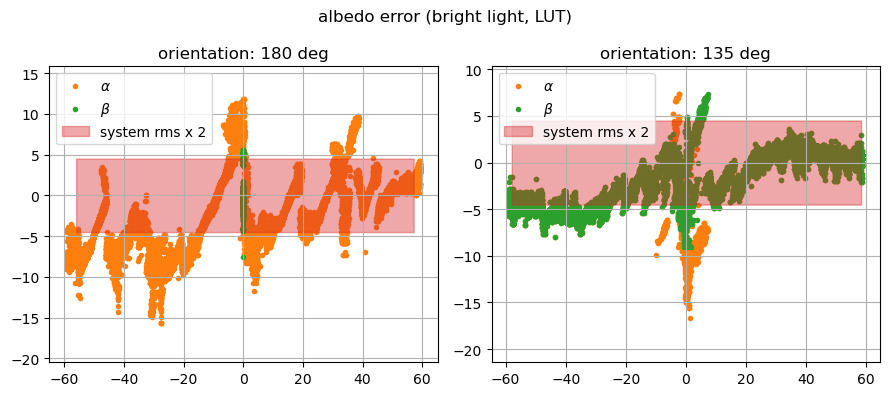

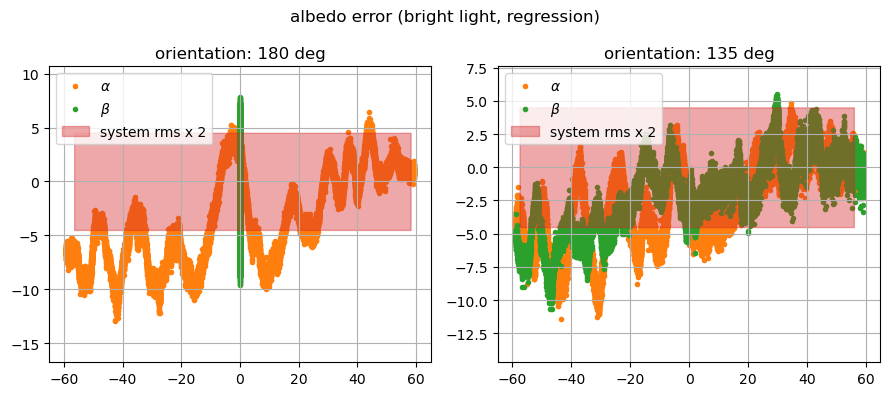

In [157]:
# now look at just the difference between two measurements
# since this is so vague, plot the datasets separately:
LUT_test_data = apply_table(test_data, table)
LUT_bright_data = apply_table(bright_albedo_data_45, table)
bright_albedo_plot_unbaffled_LUT_45 = os.path.join(unbaffled_dir, "bright_albedo_plot_unbaffled_LUT_45.png")
bright_albedo_plots(LUT_test_data, LUT_bright_data, "albedo error (bright light, LUT)", base_rms = rms_dict["LUT"], save=True, path = bright_albedo_plot_unbaffled_LUT_45)

LUT_test_data = apply_OLS(test_data, estimator_alpha_1, estimator_beta_1, bias = True)
LUT_bright_data = apply_OLS(bright_albedo_data_45, estimator_alpha_1, estimator_beta_1, bias = True)
bright_albedo_plot_4_unbaffled_reg_5 = os.path.join(unbaffled_dir, "bright_albedo_plot_unbaffled_reg_45.png")
bright_albedo_plots(LUT_test_data, LUT_bright_data, "albedo error (bright light, regression)", base_rms = rms_dict["LUT"], save=True, path = bright_albedo_plot_4_unbaffled_reg_5)

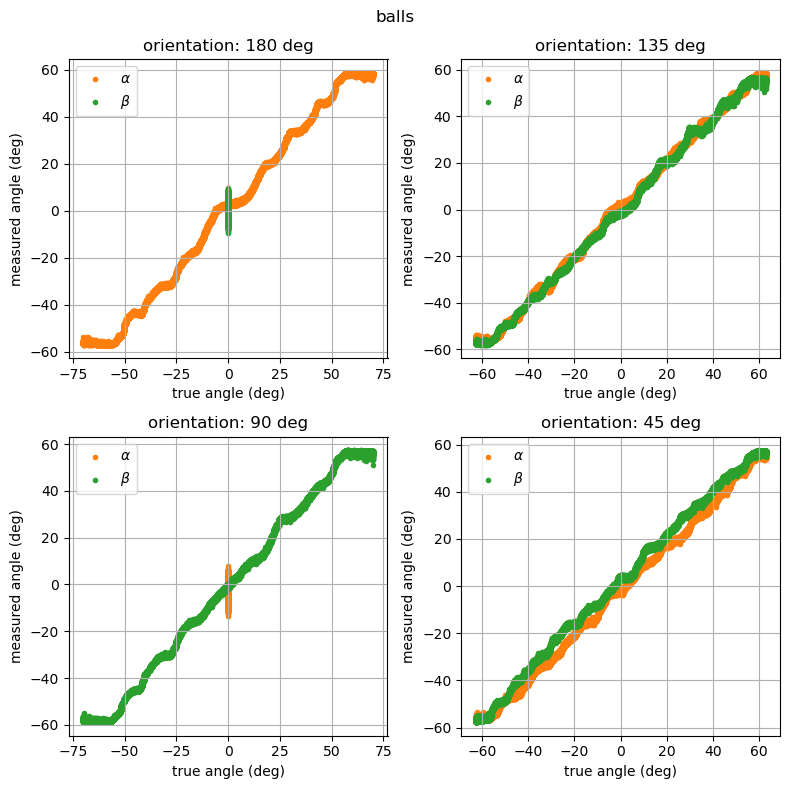

In [159]:
generic_angles(LUT_test_data,"balls")

Below is the calibrated baffled data

working with calibration method: raw_baffled


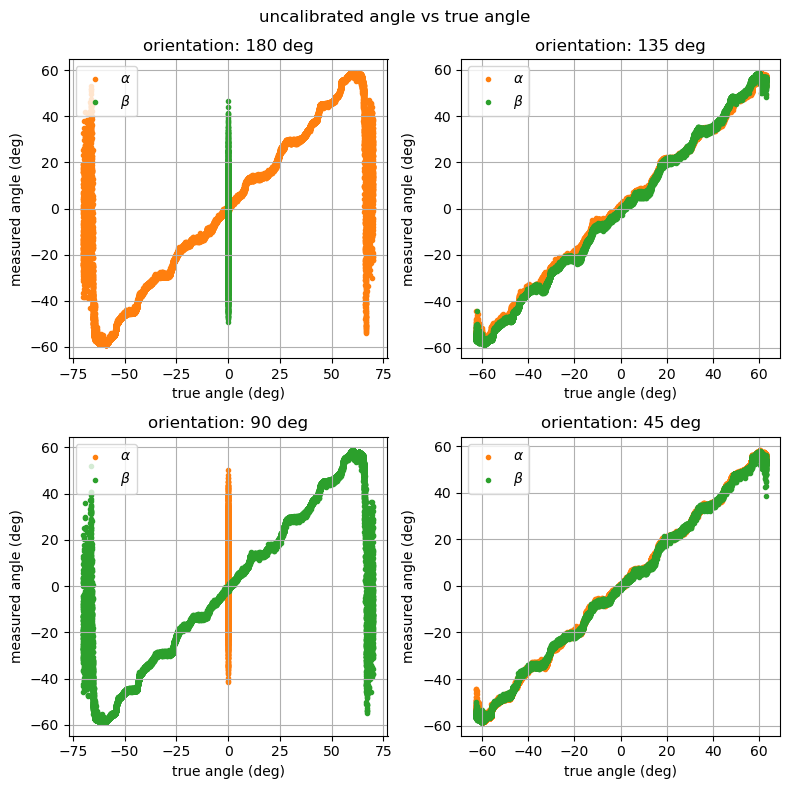

3.4801112360402096


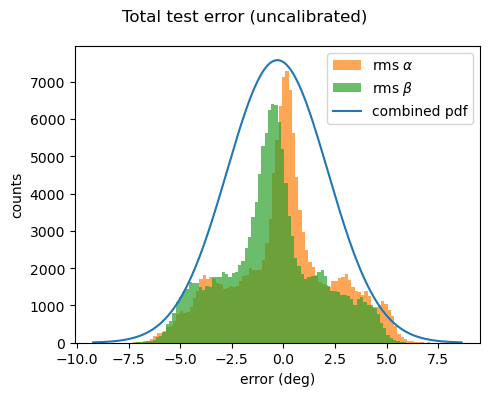

[{'dof': 145200, 'chi': 574214.0032244109, 'crit': 146087.52703094852, 'goal error (2sigma)': 3.5, 'failure fraction': 0.4047451790633609, 'measured rms': 3.48011123604021}, {'dof': 145200, 'chi': 1758530.3848747585, 'crit': 146087.52703094852, 'goal error (2sigma)': 2.0, 'failure fraction': 0.6396487603305785, 'measured rms': 3.48011123604021}, {'dof': 145200, 'chi': 7034121.539499034, 'crit': 146087.52703094852, 'goal error (2sigma)': 1.0, 'failure fraction': 0.8411570247933884, 'measured rms': 3.48011123604021}]
end
working with calibration method: bias_baffled


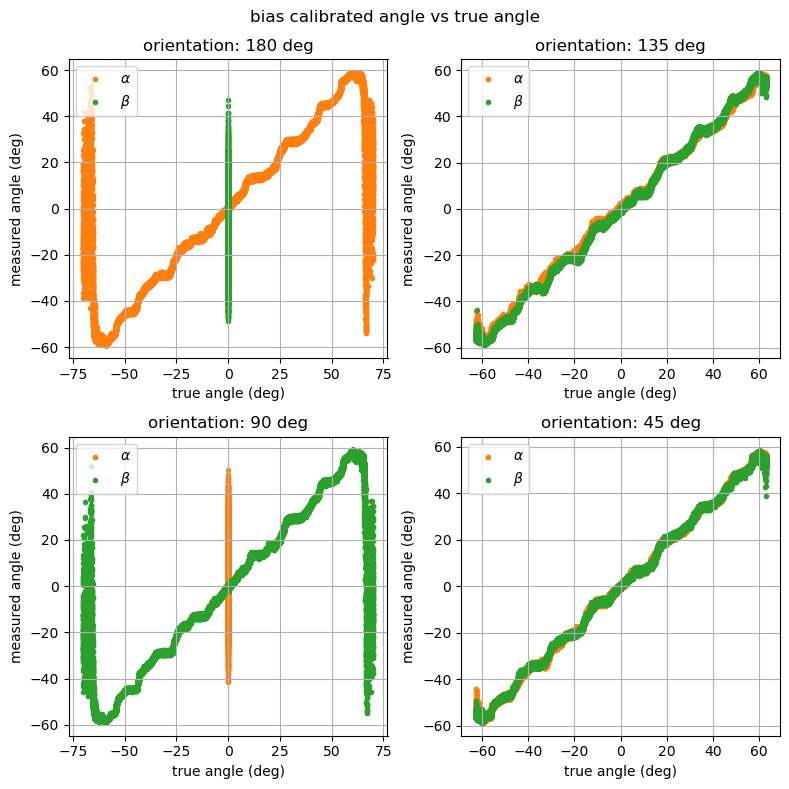

3.4478462469033566


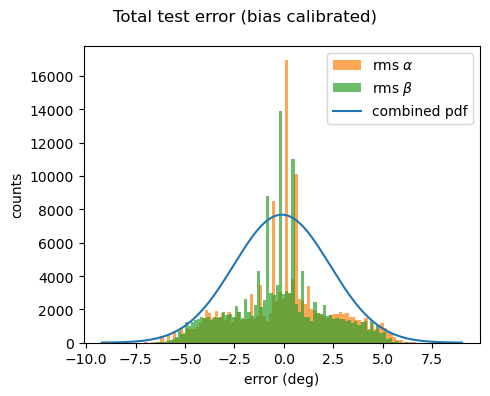

[{'dof': 145200, 'chi': 563615.9946893457, 'crit': 146087.52703094852, 'goal error (2sigma)': 3.5, 'failure fraction': 0.40165289256198344, 'measured rms': 3.4478462469033566}, {'dof': 145200, 'chi': 1726073.9837361213, 'crit': 146087.52703094852, 'goal error (2sigma)': 2.0, 'failure fraction': 0.6301308539944903, 'measured rms': 3.4478462469033566}, {'dof': 145200, 'chi': 6904295.934944485, 'crit': 146087.52703094852, 'goal error (2sigma)': 1.0, 'failure fraction': 0.8075137741046832, 'measured rms': 3.4478462469033566}]
end
working with calibration method: reg_baffled


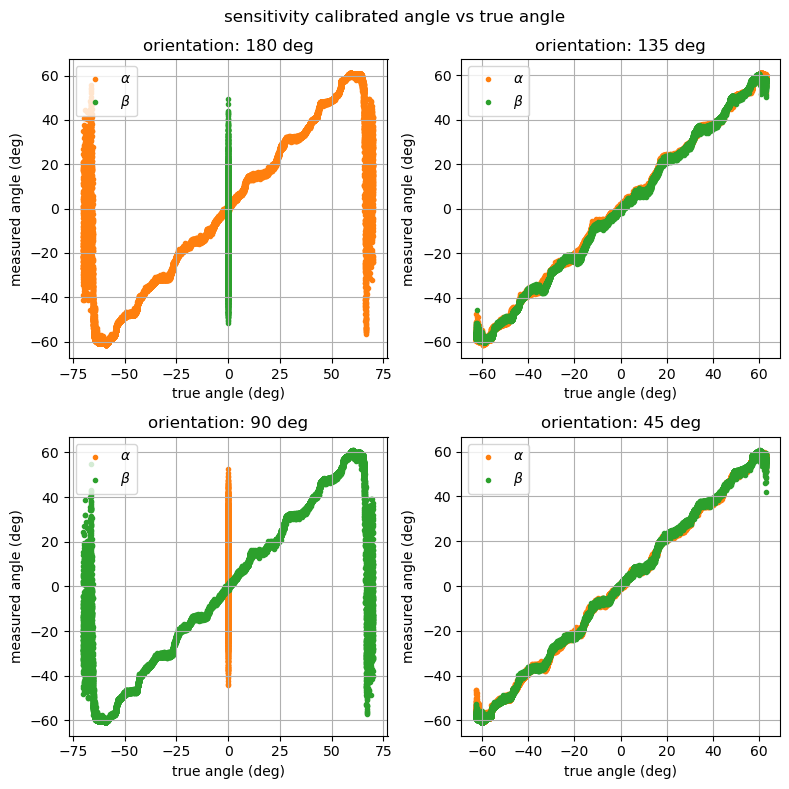

2.2525701078636646


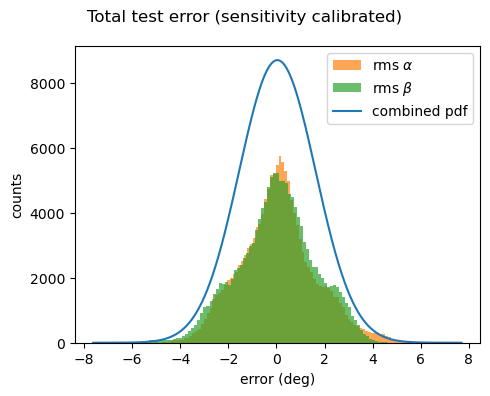

[{'dof': 145200, 'chi': 240571.4917609832, 'crit': 146087.52703094852, 'goal error (2sigma)': 3.5, 'failure fraction': 0.10135674931129476, 'measured rms': 2.2525701078636646}, {'dof': 145200, 'chi': 736750.193518011, 'crit': 146087.52703094852, 'goal error (2sigma)': 2.0, 'failure fraction': 0.43724517906336086, 'measured rms': 2.2525701078636646}, {'dof': 145200, 'chi': 2947000.774072044, 'crit': 146087.52703094852, 'goal error (2sigma)': 1.0, 'failure fraction': 0.7545798898071625, 'measured rms': 2.2525701078636646}]
end
working with calibration method: LUT_baffled
(2, 40300)
(2, 1452)
(2, 40300)
(2, 1452)
(2, 40300)
(2, 1452)
(2, 40300)
(2, 1452)


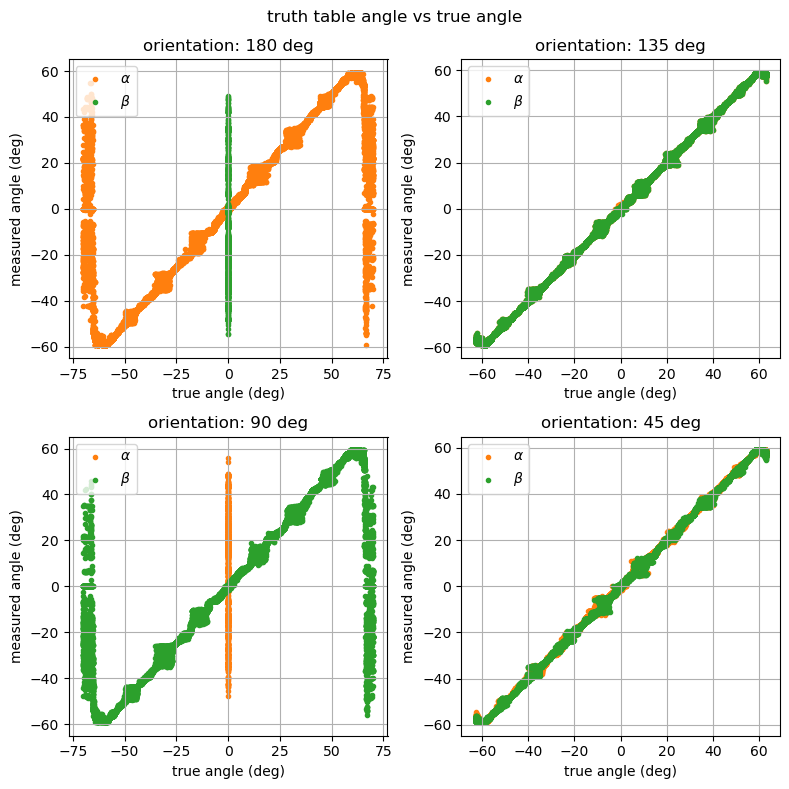

1.2017047753412011


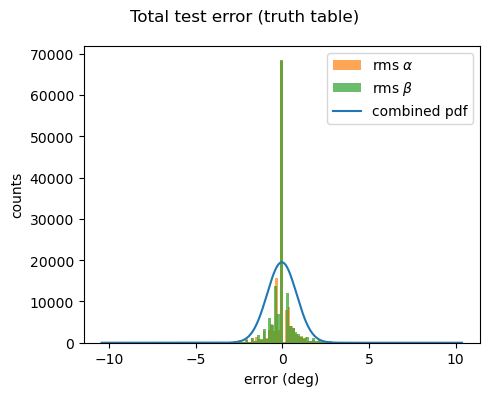

[{'dof': 145200, 'chi': 68467.28424664041, 'crit': 146087.52703094852, 'goal error (2sigma)': 3.5, 'failure fraction': 0.026246556473829202, 'measured rms': 1.2017047753412011}, {'dof': 145200, 'chi': 209681.05800533626, 'crit': 146087.52703094852, 'goal error (2sigma)': 2.0, 'failure fraction': 0.086267217630854, 'measured rms': 1.2017047753412011}, {'dof': 145200, 'chi': 838724.2320213451, 'crit': 146087.52703094852, 'goal error (2sigma)': 1.0, 'failure fraction': 0.26096418732782367, 'measured rms': 1.2017047753412011}]
end


In [182]:
# calibrate the baffled data and plot its quantities
# calibration step for unbaffled data
baffled_bias = get_offset(calb_data_baffled)
baffled_table = lookup_table(calb_data_baffled)
# calculate the estimator using calibration data [0], test it on [1]
baffled_estimator_alpha_1 = OLS(calb_data_baffled, yval="alpha", add_bias = True)
baffled_estimator_beta_1 = OLS(calb_data_baffled, yval="beta", add_bias = True)
baffled_plots = os.path.join(plots,"baffled")

# make a script that calculates te chisquare value at each calibration method for 1.0, 2.0, and 3.5 degree
goals = [3.5,2.0,1.0]
calibrations_baffled = ["raw_baffled", "bias_baffled", "reg_baffled", "LUT_baffled"]
titles_baffled = ["uncalibrated, baffled", "bias calibrated, baffled", "sensitivity calibrated, baffled", "truth table, baffled"]
baffled_plots = os.path.join(plots,"baffled")
p_info_baffled = {"raw_baffled": [], "bias_baffled": [], "reg_baffled": [], "LUT_baffled": []}
baffled_rms_dict = {"raw_baffled": [], "bias_baffled": [], "reg_baffled": [], "LUT_baffled": []}
for i, method in enumerate(calibrations_baffled):
    print("working with calibration method:", method)
    if method=="raw_baffled":
        calibrated_testdata_baffled = test_data_baffled
    elif method=="bias_baffled":
        calibrated_testdata_baffled = apply_offset(test_data_baffled, baffled_bias)
    elif method=="reg_baffled":
        calibrated_testdata_baffled = apply_OLS(test_data_baffled, baffled_estimator_alpha_1, baffled_estimator_beta_1, bias = True)
    elif method=="LUT_baffled":
        calibrated_testdata_baffled = apply_table(test_data_baffled, baffled_table)
    test_save_plot_baffled = os.path.join(plots,f"test_save_{method}_plot.png")
    generic_angles(calibrated_testdata_baffled, f"{titles[i]} angle vs true angle", save = True, path = test_save_plot_baffled)
    test_error_plot_baffled = os.path.join(baffled_plots,f"test_save_{method}_error.png")
    baffled_euc_err, baffled_rms = error_distribution(calibrated_testdata_baffled, title = f"Total test error ({titles[i]})", save = True, path = test_error_plot_baffled, separate=True)
    baffled_rms_dict[method] = baffled_rms
    for k in range(3):
        p_info_baffled[method].append(chi_calculator(baffled_euc_err, error_goal = goals[k], interval = 0.05))
    print(p_info_baffled[method])
    print("end")

In [181]:
baffled_rms_dict

{'raw_baffled': 3.4801112360402096,
 'bias_baffled': 3.4478462469033566,
 'reg_baffled': 2.2525701078636646,
 'LUT_baffled': 1.2017047753412011}

In [183]:
rms_dict

{'raw': 5.151232093196278,
 'bias': 3.786848872982114,
 'reg': 3.1209150947178523,
 'LUT': 2.2527610481569726}

Discontinuities in the cells are preventing "good" calibration

0


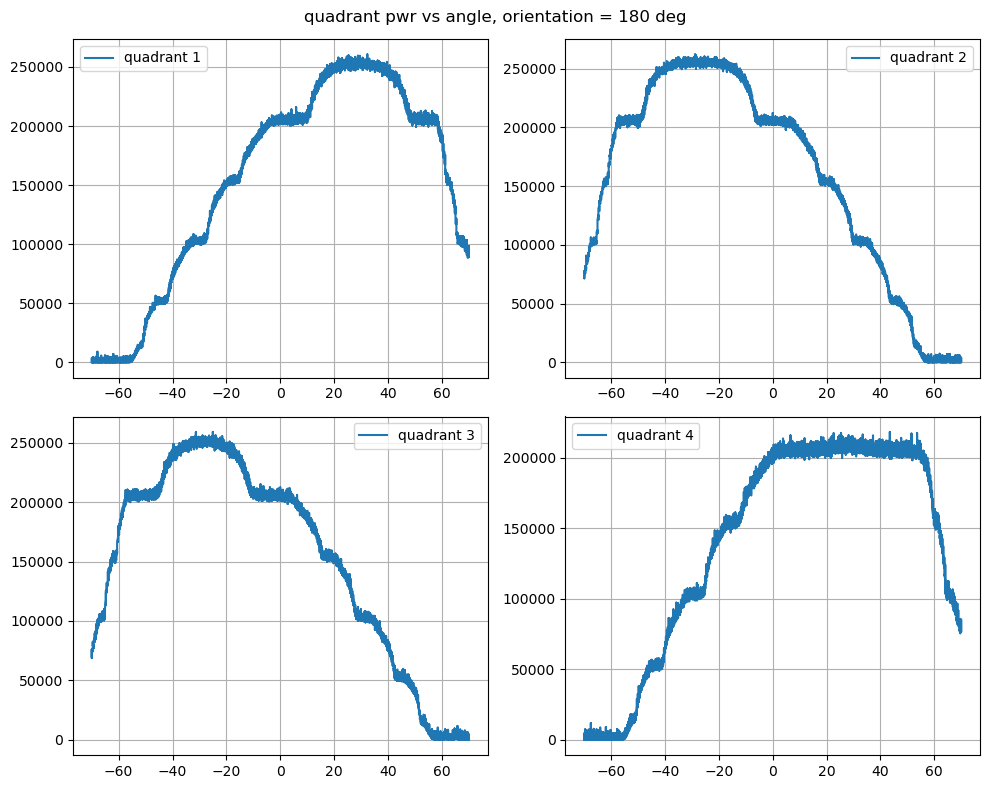

'bitch'

In [34]:
def plot_quadrant(data_set, orientation, true_angle = "alpha", title = None, save = False, path = None):
    assert true_angle in ["alpha", "beta"]
    true_angle = 0
    if true_angle == "beta":
        true_angle = 1
    orientations = np.array([180,135,90,45])
    oidx = np.where(orientations == orientation)[0][0]
    print(oidx)
    angle = data_set[oidx]["true_angles"][true_angle]
    fig, ax = plt.subplots(nrows=2,ncols=2,figsize = (10,8))
    for k in range(4):
        quad_data = data_set[oidx]["quadrants"][k]
        j, i = k, 0
        if k > 1:
            j, i = k - 2, 1
        ax[i][j].plot(angle, quad_data, label = f"quadrant {k+1}")
        ax[i][j].grid()
        ax[i][j].legend()
    fig.suptitle(title)
    plt.tight_layout()
    if save:
        plt.savefig(path)
    plt.show()
    plt.close()
    return "bitch"

sussy_quadrants = os.path.join(plots,"sussy_quadrants.png")
plot_quadrant(test_data, 180, "alpha", "quadrant pwr vs angle, orientation = 180 deg", save =True, path = sussy_quadrants)

In [ ]:
# write a script that plots the difference between the measured angle and the albedo influenced angle
# begin by plotting the calibrated albedo data from the quadrants